In [1]:
from util import *

2024-01-02 02:16:01.829000: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-02 02:16:01.829059: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-02 02:16:01.829926: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-02 02:16:01.834683: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-02 02:16:02.395612: W tensorflow/compiler/tf2

In [2]:
EXTRACT_FEATRURES = True

In [3]:
train_dir = 'Dataset/train_clean.txt'
val_dir = 'Dataset/val_clean.txt'
test_dir = 'Dataset/test_clean.txt'

In [4]:
with open(train_dir, 'r', encoding='utf8') as f:
    train = f.read()
with open(val_dir, 'r', encoding='utf8') as f:
    val = f.read()
with open(test_dir, 'r', encoding='utf8') as f:
    test = f.read()

In [5]:
max_len = 1000

In [6]:
X_train_dir = 'pkl_dir/X_train.txt'
y_train_dir = 'pkl_dir/y_train.txt'
X_val_dir = 'pkl_dir/X_val.txt'
y_val_dir = 'pkl_dir/y_val.txt'
X_test_dir = 'pkl_dir/X_test.txt'
y_test_dir = 'pkl_dir/y_test.txt'

if EXTRACT_FEATRURES:
    X_train, y_train = extract_features(train, max_len)
    X_val, y_val = extract_features(val, max_len)
    X_test, y_test = extract_features(test, max_len)

    with open(X_train_dir, 'wb') as f:
        pickle.dump(X_train, f)
    with open(y_train_dir, 'wb') as f:
        pickle.dump(y_train, f)
    with open(X_val_dir, 'wb') as f:
        pickle.dump(X_val, f)
    with open(y_val_dir, 'wb') as f:
        pickle.dump(y_val, f)
    with open(X_test_dir, 'wb') as f:
        pickle.dump(X_test, f)
    with open(y_test_dir, 'wb') as f:
        pickle.dump(y_test, f)

else:
    with open(X_train_dir, 'rb') as f:
        X_train = pickle.load(f)
    with open(y_train_dir, 'rb') as f:
        y_train = pickle.load(f)
    with open(X_val_dir, 'rb') as f:
        X_val = pickle.load(f)
    with open(y_val_dir, 'rb') as f:
        y_val = pickle.load(f)
    with open(X_test_dir, 'rb') as f:
        X_test = pickle.load(f)
    with open(y_test_dir, 'rb') as f:
        y_test = pickle.load(f)

In [7]:
j = 1
i = 7
for i in range(50):
    print(chr(X_train[j][i]), end='')
    print(id2diacritic[y_train[j][i]], end='')

( قَوْلُهُ لِعَدَمِ مَا تَتَعَلَّقُ إلَخْ ) أَيْ الْوَصِيَّةُ ( قَوْلُهُ مَا مَرَّ

In [8]:
test_len = 5000
np.random.seed(42)
indices = np.arange(test_len)
np.random.shuffle(indices)
X_test = X_test[indices]
y_test = y_test[indices]

In [9]:

sentence_encoder = LabelEncoder().fit(X_train.flatten())
# sentence_encoder = pickle.load(open('sentence_encoders/sentence_encoder_1000.pkl', 'rb'))          # conv_1000
X_train = sentence_encoder.transform(X_train.flatten()).reshape(X_train.shape).astype(np.int16)
X_val = sentence_encoder.transform(X_val.flatten()).reshape(X_val.shape).astype(np.int16)
X_test = sentence_encoder.transform(X_test.flatten()).reshape(X_test.shape).astype(np.int16)

In [10]:
def batch_eval(x_np, y_np):
    X_tensor = torch.tensor(x_np, dtype=torch.int32)
    y_tensor = torch.tensor(y_np, dtype=torch.int32)
    model.eval()
    predictions = torch.zeros_like(y_tensor)

    with torch.no_grad():
        for i in range(0, len(X_tensor), batch_size):
            inputs = X_tensor[i:i+batch_size].to(device)
            outputs = model(inputs)
            _, predictions[i:i+batch_size] = torch.max(outputs.data, 2)
            del inputs, outputs

    return predictions.cpu().numpy()

In [11]:
def compute_DER(X, y):
    predictions = batch_eval(X, y)
    ignore = {PAD, SOS, EOS, '!', '«', ']', '[', '}', ':', '"', '-', '»', '؛', ')', '،', '؟', '(', '{', '/', ' '}
    cnt = 0
    for itm in ignore:
        cnt += np.sum(X == sentence_encoder.transform(np.array([ord(itm)]))[0])
    accuracy = (np.sum(predictions == y) - cnt) / (predictions.shape[0] * predictions.shape[1] - cnt)
    acc_t = np.sum(predictions == y) / (predictions.shape[0] * predictions.shape[1])
    return 1 - accuracy, acc_t

In [12]:
X_train = np.concatenate((X_train, X_val))
y_train = np.concatenate((y_train, y_val))

In [13]:
import torch
torch.cuda.is_available()

True

In [14]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F
from typing import List, Optional

class NewModel(nn.Module):
    def __init__(self):
        super(NewModel, self).__init__()
        self.embedding = nn.Embedding(num_embeddings=56, embedding_dim=25)

        # Add Conv1d layer
        self.conv1 = nn.Conv1d(in_channels=25, out_channels=256, kernel_size=11, padding=5)
        self.bn_conv1 = nn.BatchNorm1d(max_len)
        self.dropout_conv1 = nn.Dropout(p=0.5)

        self.lstm1 = nn.LSTM(input_size=256, hidden_size=256, batch_first=True, bidirectional=True)
        self.bn1 = nn.BatchNorm1d(max_len)
        self.dropout1 = nn.Dropout(p=0.5)

        self.conv2 = nn.Conv1d(in_channels=512, out_channels=512, kernel_size=5, padding=2)
        self.bn_conv2 = nn.BatchNorm1d(max_len)
        self.dropout_conv2 = nn.Dropout(p=0.5)

        self.lstm2 = nn.LSTM(input_size=512, hidden_size=256, batch_first=True, bidirectional=True)
        self.bn2 = nn.BatchNorm1d(max_len)
        self.dropout2 = nn.Dropout(p=0.5)

        self.conv3 = nn.Conv1d(in_channels=512, out_channels=512, kernel_size=3, padding=1)
        self.bn_conv3 = nn.BatchNorm1d(max_len)
        self.dropout_conv3 = nn.Dropout(p=0.5)

        self.dense1 = nn.Linear(in_features=512, out_features=512)
        self.bn3 = nn.BatchNorm1d(max_len)

        self.dense2 = nn.Linear(in_features=512, out_features=512)
        self.bn4 = nn.BatchNorm1d(max_len)
        
        self.dense3 = nn.Linear(in_features=512, out_features=15)

    def forward(self, x):
        x = self.embedding(x)

        # Apply Conv1d layer
        x = x.permute(0, 2, 1)  # Change to (batch_size, channels, seq_len)
        x = F.relu(self.conv1(x))
        x = x.permute(0, 2, 1)  # Change back to (batch_size, seq_len, channels)
        x = self.bn_conv1(x)
        x = self.dropout_conv1(x)

        x, _ = self.lstm1(x)
        x = self.bn1(x)
        x = self.dropout1(x)

        x = x.permute(0, 2, 1)  # Change to (batch_size, channels, seq_len)
        x = F.relu(self.conv2(x))
        x = x.permute(0, 2, 1)
        x = self.bn_conv2(x)
        x = self.dropout_conv2(x)

        x, _ = self.lstm2(x)
        x = self.bn2(x)
        x = self.dropout2(x)

        x = x.permute(0, 2, 1)  # Change to (batch_size, channels, seq_len)
        x = F.relu(self.conv3(x))
        x = x.permute(0, 2, 1)
        x = self.bn_conv3(x)
        x = self.dropout_conv3(x)

        x = F.relu(self.bn3(self.dense1(x)))
        x = F.relu(self.bn4(self.dense2(x)))

        x = self.dense3(x)
        return x

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = NewModel().to(device)
model = torch.load('model_conv_1000.ckpt', map_location=device)
criterion = nn.CrossEntropyLoss()
learning_rate = 0.0004
optimizer = optim.Adam(model.parameters(), lr=learning_rate, eps=1e-7)
print(learning_rate)

0.0004


In [15]:
# import torch
# import torch.nn as nn
# import torch.optim as optim
# from torch.utils.data import DataLoader, TensorDataset
# import torch.nn.functional as F
# from typing import List, Optional

# class Model(nn.Module):
#     def __init__(self):
#         super(Model, self).__init__()
#         self.embedding = nn.Embedding(num_embeddings=np.unique(X_train).shape[0], embedding_dim=25)

#         self.prenet = nn.Linear(in_features=25, out_features=256)
#         self.bnpre = nn.BatchNorm1d(max_len)
#         self.dropoutpre = nn.Dropout(p=0.5)

#         self.lstm1 = nn.GRU(input_size=256, hidden_size=256, batch_first=True, bidirectional=True)
#         self.bn1 = nn.BatchNorm1d(max_len)
#         self.dropout1 = nn.Dropout(p=0.5)
        
#         self.lstm2 = nn.GRU(input_size=512, hidden_size=256, batch_first=True, bidirectional=True)
#         self.bn2 = nn.BatchNorm1d(max_len)
#         self.dropout2 = nn.Dropout(p=0.5)

#         self.lstm3 = nn.GRU(input_size=512, hidden_size=256, batch_first=True, bidirectional=True)
#         self.bn3 = nn.BatchNorm1d(max_len)
#         self.dropout3 = nn.Dropout(p=0.5)

#         self.dense1 = nn.Linear(in_features=512, out_features=512)
#         self.bnd1 = nn.BatchNorm1d(max_len)

#         self.dense2 = nn.Linear(in_features=512, out_features=512)
#         self.bnd2 = nn.BatchNorm1d(max_len)
        
#         self.dense3 = nn.Linear(in_features=512, out_features=np.unique(y_train).shape[0])

#     def forward(self, x):
#         x = self.embedding(x)

#         x = self.prenet(x)
#         x = self.bnpre(x)
#         x = self.dropoutpre(x)


#         x, _ = self.lstm1(x)
#         x = self.bn1(x)
#         x = self.dropout1(x)

#         x, _ = self.lstm2(x)
#         x = self.bn2(x)
#         x = self.dropout2(x)

#         x, _ = self.lstm3(x)
#         x = self.bn3(x)
#         x = self.dropout3(x)



#         x = F.relu(self.bnd1(self.dense1(x)))
#         x = F.relu(self.bnd2(self.dense2(x)))

#         x = self.dense3(x)
#         return x
    

# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model = Model().to(device)
# model = torch.load('model_3gru.ckpt', map_location=device)
# criterion = nn.CrossEntropyLoss()
# learning_rate = 0.0004
# optimizer = optim.Adam(model.parameters(), lr=learning_rate, eps=1e-7)
# print(learning_rate)


In [16]:
batch_size = 120
print(batch_size)

120


In [17]:
# num_epochs = 20
# for epoch in range(num_epochs):
#     model.train()

#     X_train_tensor = torch.tensor(X_train, dtype=torch.int64).to(device)
#     y_train_tensor = torch.tensor(y_train, dtype=torch.int64).to(device)
#     train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
#     train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    
#     accuracy = 0
#     loss_cum_sum = 0
#     len_ = 0
#     for i, (x, y) in enumerate(train_loader):
#         optimizer.zero_grad()
#         outputs = model(x)
#         loss = criterion(outputs.view(-1, np.unique(y_train).shape[0]), y.view(-1))
#         loss.backward()
#         optimizer.step()
#         _, predicted = torch.max(outputs.data, 2)
#         accuracy += (predicted == y).sum().item()
#         loss_cum_sum += loss.item()
#         len_ += y.size(0) * y.size(1)
#         if (i + 1) % 1 == 0:
#             print('Step [{}/{}], Epoch [{}/{}], Loss: {:.4f}, Accuracy: {:.4f}'.format(i + 1, len(train_loader), epoch + 1, num_epochs, loss_cum_sum / (i + 1), accuracy / len_), end='\r')
#     print()
#     del X_train_tensor, y_train_tensor, train_dataset, train_loader
#     DER, acc_t = compute_DER(X_test, y_test)
#     print('Test DER: {:.5f}, Test Accuracy: {:.4f}\n'.format(DER, acc_t))

In [18]:
# save model
# torch.save(model, 'model_3gru.ckpt')
# torch.save(model, 'model_conv_m_newcleaner.ckpt')
print(np.unique(y_train).shape[0])
print(np.unique(X_train).shape[0])

15
56


In [19]:
print(max_len)
sentence_test_str = "ليس للوكيل بالقبض أن يبرأ المدين أو يهب الدين له أو يأخذ رهنا من المدين في مقابل الدين أو يقبل إحالته على شخص آخر لكن له أن يأخذ كفيلا لكن ليس له أن يأخذ كفيلا بشرط براءة الأصيل انظر المادة ( 648 ) ( الأنقروي ، الطحطاوي وصرة الفتاوى ، البحر ) ."
# sentence_encoder = pickle.load(open('sentence_encoders/sentence_encoder_1000.pkl', 'rb'))         # 1000
# sentence_encoder = pickle.load(open('sentence_encoders/sentence_encoder_1000.pkl', 'rb'))          # cbhg, 600
# model = torch.load('model_conv_m.ckpt', map_location=device)

# sentence_encoder = pickle.load(open('sentence_encoders/sentence_encoder_500.pkl', 'rb'))          # conv_m, 500
sentence12, sentence22, label22, id22 = Test(sentence_test_str, model, sentence_encoder, max_len)
golden_output = np.array([0, 6, 0, 4, 6, 0, 4, 14, 4, 4, 14, 6, 0, 6, 4, 0, 6, 2, 0, 12, 0, 14, 6, 0, 4, 14, 0, 0, 6, 0, 0, 0, 14, 14, 8, 6, 0, 0, 2, 0, 6, 0, 6, 2, 0, 0, 6, 1, 14, 4, 6, 14, 6, 0, 4, 14, 4, 4, 14, 2, 0, 14, 4, 4, 14, 14, 8, 6, 4, 0, 6, 0, 6, 0, 0, 14, 0, 14, 0, 0, 2, 0, 0, 14, 0, 6, 5, 14, 0, 0, 0, 4, 6, 0, 2, 0, 6, 0, 6, 2, 0, 0, 4, 14, 1, 14, 0, 4, 6, 0, 6, 0, 0, 2, 0, 6, 0, 6, 2, 0, 0, 4, 14, 1, 14, 4, 0, 6, 4, 0, 0, 14, 0, 4, 14, 6, 0, 4, 14, 4, 2, 6, 2, 6, 14, 6, 0, 14, 8, 0, 14, 6, 0, 6, 4, 6, 4, 10, 14, 14, 8, 6, 0, 14, 4, 10, 0, 2, 8, 2, 14, 6, 0, 0, 14, 0, 14, 14, 6, 0, 6, 2])

x = np.array(label22[:len(golden_output)])
for i in range(len(x)):
    if (x[i] != golden_output[i]):
        print(f'{i}: {x[i]}, {golden_output[i]}')
    # print(f'{x[i]} {golden_output[i]}')
print(f'{sum(x==golden_output)} correct out of {len(x)}')
print(sum(x==golden_output)/len(x) * 100, "%")

# print(model)

1000
17: 0, 2
18: 6, 0
19: 0, 12
23: 2, 0
24: 8, 4
25: 6, 14
26: 4, 0
44: 2, 0
46: 2, 6
47: 0, 1
54: 8, 4
55: 6, 14
59: 0, 2
63: 14, 4
72: 0, 6
73: 6, 0
79: 4, 0
80: 4, 2
89: 5, 0
90: 4, 0
100: 2, 0
102: 0, 4
104: 14, 1
106: 4, 0
112: 2, 0
113: 14, 2
117: 0, 6
118: 6, 2
119: 6, 0
121: 0, 4
123: 0, 1
133: 2, 4
137: 6, 4
139: 14, 4
140: 14, 2
141: 2, 6
143: 14, 6
149: 14, 0
154: 0, 4
155: 0, 6
157: 14, 10
161: 14, 6
162: 2, 0
164: 14, 4
165: 14, 10
167: 0, 2
168: 0, 8
169: 0, 2
181: 4, 2
133 correct out of 182
73.07692307692307 %


/home/ali/.local/lib/python3.10/site-packages/torch/nn/modules/conv.py:306: UserWarning: Applied workaround for CuDNN issue, install nvrtc.so (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:80.)
  return F.conv1d(input, weight, bias, self.stride,


In [20]:
DER, acc_t = compute_DER(X_test, y_test)
print('DER: {:.8f}'.format(DER))
print('score: {:.8f}'.format(1-DER))

DER: 0.02243741
score: 0.97756259


In [21]:
# 3ayza tet7at fy trainer copy aw 7aga b3d kda 3lshan teshta8al
# w yet7at m3aha function clean brdo xD

def Test(test_sentences, model, sentence_encoder, max_len = 500):
    # test_sentences: el text el kbeer bta3 el test (kaza gomla 3ady b dots b 3ak kteer kda)
    # model: el model el hn-predict byh
    # sentence_encoder: el encoder el hn-convert el text le numbers
    test_sentences_clean = clean(test_sentences)
    test_sentences_clean = test_sentences_clean.split('.')
    # split on \n as well, la mlhash lazma
    
    for test in test_sentences_clean:
        if test == '':      # fy gomal fyha . w \n, fa hyb2a fady, bnshelha
            test_sentences_clean.remove(test)
    # split 3la no2ta wa7da msh aktr, w \n 
    # kda kda el clean bysheel el kaza no2ta

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    sentence1 = ''
    sentence2 = ''
    label2 = []
    # arabic_letters = {'ء', 'آ', 'أ', 'ؤ', 'إ', 'ئ', 'ا', 'ب', 'ة', 'ت', 'ث', 'ج', 'ح', 'خ', 'د', 'ذ', 'ر', 'ز', 'س','ش', 'ص', 'ض', 'ط', 'ظ', 'ع', 'غ', 'ف', 'ق', 'ك', 'ل', 'م', 'ن', 'ه', 'و', 'ى', 'ي'}
    
    for sentence in test_sentences_clean:
        sentence = SOS + sentence + EOS
        for j in range(0, len(sentence), max_len//2):
            current_sentence = sentence[j:j+max_len]
            
            current_sentence, labels = clamp_sentence(current_sentence, np.full((len(current_sentence)), diacritic2id[''], dtype = np.uint8), max_len)
            test_sentence_clean = encode_sentence(current_sentence)
            test_sentence_clean = sentence_encoder.transform(test_sentence_clean.reshape(-1)).reshape(1, -1)
            
            test_sentence_clean = torch.tensor(test_sentence_clean, dtype=torch.int32).to(device)
            outputs = model(test_sentence_clean)
            _, pred = torch.max(outputs.data, 2)
            pred = pred.cpu().numpy().reshape(-1)

            for i in range(len(current_sentence)):
                sentence1 += current_sentence[i]
                sentence1 += id2diacritic[pred[i]]
            sentence1 += '\n'

            
            if j == 0:
                flag = np.array([ord('ء') <= ord(c) <= ord('ي') for c in current_sentence])

                current_sentence = np.array(list(current_sentence))
                pred = pred[flag]
                
            else:
                flag = np.array([ord('ء') <= ord(c) <= ord('ي') for c in current_sentence[max_len//2:]])

                current_sentence = np.array(list(current_sentence[max_len//2:]))
                pred = pred[max_len//2:][flag]
                
            
            current_sentence = current_sentence[flag]
            sentence2 += ''.join(current_sentence)
            label2 += list(pred)

    id2 = np.arange(len(sentence2))
            
    return sentence1[1:-1], sentence2, label2, id2
# model = torch.load('model_conv.ckpt', map_location=torch.device('cpu'))       # 3lshan t-load el model 3l cpu

In [22]:
print(max_len)
sentence_test_str = "ليس للوكيل بالقبض أن يبرأ المدين أو يهب الدين له أو يأخذ رهنا من المدين في مقابل الدين أو يقبل إحالته على شخص آخر لكن له أن يأخذ كفيلا لكن ليس له أن يأخذ كفيلا بشرط براءة الأصيل انظر المادة ( 648 ) ( الأنقروي ، الطحطاوي وصرة الفتاوى ، البحر ) ."
# sentence_encoder = pickle.load(open('sentence_encoders/sentence_encoder_1000.pkl', 'rb'))         # 1000
# sentence_encoder = pickle.load(open('sentence_encoders/sentence_encoder_1000.pkl', 'rb'))          # cbhg, 600
# model = torch.load('model_conv_m.ckpt', map_location=device)

# sentence_encoder = pickle.load(open('sentence_encoders/sentence_encoder_500.pkl', 'rb'))          # conv_m, 500
sentence12, sentence22, label22, id22 = Test(sentence_test_str, model, sentence_encoder, max_len)
golden_output = np.array([0, 6, 0, 4, 6, 0, 4, 14, 4, 4, 14, 6, 0, 6, 4, 0, 6, 2, 0, 12, 0, 14, 6, 0, 4, 14, 0, 0, 6, 0, 0, 0, 14, 14, 8, 6, 0, 0, 2, 0, 6, 0, 6, 2, 0, 0, 6, 1, 14, 4, 6, 14, 6, 0, 4, 14, 4, 4, 14, 2, 0, 14, 4, 4, 14, 14, 8, 6, 4, 0, 6, 0, 6, 0, 0, 14, 0, 14, 0, 0, 2, 0, 0, 14, 0, 6, 5, 14, 0, 0, 0, 4, 6, 0, 2, 0, 6, 0, 6, 2, 0, 0, 4, 14, 1, 14, 0, 4, 6, 0, 6, 0, 0, 2, 0, 6, 0, 6, 2, 0, 0, 4, 14, 1, 14, 4, 0, 6, 4, 0, 0, 14, 0, 4, 14, 6, 0, 4, 14, 4, 2, 6, 2, 6, 14, 6, 0, 14, 8, 0, 14, 6, 0, 6, 4, 6, 4, 10, 14, 14, 8, 6, 0, 14, 4, 10, 0, 2, 8, 2, 14, 6, 0, 0, 14, 0, 14, 14, 6, 0, 6, 2])

x = np.array(label22[:len(golden_output)])
for i in range(len(x)):
    if (x[i] != golden_output[i]):
        print(f'{i}: {x[i]}, {golden_output[i]}')
    # print(f'{x[i]} {golden_output[i]}')
print(f'{sum(x==golden_output)} correct out of {len(x)}')
print(sum(x==golden_output)/len(x) * 100, "%")

# print(model)

1000
17: 0, 2
18: 6, 0
19: 0, 12
179 correct out of 182
98.35164835164835 %


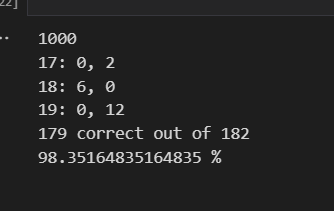

In [23]:
DER, acc_t = compute_DER(X_test, y_test)
print('DER: {:.8f}'.format(DER))
print('score: {:.8f}'.format(1-DER))

DER: 0.02243741
score: 0.97756259


In [24]:
test_path = 'Testfrfr/test_no_diacritics.txt'
with open(test_path, 'r', encoding='utf8') as f:
    test = f.read()
    
sentence1, sentence2, label2, id2 = Test(test, model, sentence_encoder, max_len)
print(len(sentence1))
print(len(sentence2))
print(len(label2))
print(len(id2))
print(sentence2[:100])


2863922
417359
417359
417359
ليسللوكيلبالقبضأنيبرأالمدينأويهبالدينلهأويأخذرهنامنالمدينفيمقابلالدينأويقبلإحالتهعلىشخصآخرلكنلهأنيأخ


In [25]:
golden_output = np.array([0, 6, 0, 4, 6, 0, 4, 14, 4, 4, 14, 6, 0, 6, 4, 0, 6, 2, 0, 12, 0, 14, 6, 0, 4, 14, 0, 0, 6, 0, 0, 0, 14, 14, 8, 6, 0, 0, 2, 0, 6, 0, 6, 2, 0, 0, 6, 1, 14, 4, 6, 14, 6, 0, 4, 14, 4, 4, 14, 2, 0, 14, 4, 4, 14, 14, 8, 6, 4, 0, 6, 0, 6, 0, 0, 14, 0, 14, 0, 0, 2, 0, 0, 14, 0, 6, 5, 14, 0, 0, 0, 4, 6, 0, 2, 0, 6, 0, 6, 2, 0, 0, 4, 14, 1, 14, 0, 4, 6, 0, 6, 0, 0, 2, 0, 6, 0, 6, 2, 0, 0, 4, 14, 1, 14, 4, 0, 6, 4, 0, 0, 14, 0, 4, 14, 6, 0, 4, 14, 4, 2, 6, 2, 6, 14, 6, 0, 14, 8, 0, 14, 6, 0, 6, 4, 6, 4, 10, 14, 14, 8, 6, 0, 14, 4, 10, 0, 2, 8, 2, 14, 6, 0, 0, 14, 0, 14, 14, 6, 0, 6, 2])

x = np.array(label2[:len(golden_output)])
print(label2[:len(golden_output)])
# for i in range(len(x)):
#     print(f'{x[i]} {golden_output[i]}')
print(f'{sum(x==golden_output)} correct out of {len(x)}')
print(sum(x==golden_output)/len(x) * 100, "%")


[0, 6, 0, 4, 6, 0, 4, 14, 4, 4, 14, 6, 0, 6, 4, 0, 6, 0, 6, 0, 0, 14, 6, 0, 4, 14, 0, 0, 6, 0, 0, 0, 14, 14, 8, 6, 0, 0, 2, 0, 6, 0, 6, 2, 0, 0, 6, 1, 14, 4, 6, 14, 6, 0, 4, 14, 4, 4, 14, 2, 0, 14, 4, 4, 14, 14, 8, 6, 4, 0, 6, 0, 6, 0, 0, 14, 0, 14, 0, 0, 2, 0, 0, 14, 0, 6, 5, 14, 0, 0, 0, 4, 6, 0, 2, 0, 6, 0, 6, 2, 0, 0, 4, 14, 1, 14, 0, 4, 6, 0, 6, 0, 0, 2, 0, 6, 0, 6, 2, 0, 0, 4, 14, 1, 14, 4, 0, 6, 4, 0, 0, 14, 0, 4, 14, 6, 0, 4, 14, 4, 2, 6, 2, 6, 14, 6, 0, 14, 8, 0, 14, 6, 0, 6, 4, 6, 4, 10, 14, 14, 8, 6, 0, 14, 4, 10, 0, 2, 8, 2, 14, 6, 0, 0, 14, 0, 14, 14, 6, 0, 6, 2]
179 correct out of 182
98.35164835164835 %


In [26]:
# pickle dump sentence2, label2, id2
# pickle.dump(sentence2, open('sentence2.pkl', 'wb'))
pickle.dump(label2, open('Answer2/label2.pkl', 'wb'))
pickle.dump(id2, open('Answer2/id2.pkl', 'wb'))

In [27]:
import csv
label2 = pickle.load(open('Answer2/label2.pkl', 'rb'))
# print(type(label2[0]))
# turn label 2 into a list instead of numpy array, using list comprehension

label = [[ind, int(val)] for ind, val in enumerate(label2)]


# Specify the file path
csv_file_path = 'Answer2/output.csv'

# Writing to CSV file
with open(csv_file_path, 'w', newline='') as csvfile:
    csv_writer = csv.writer(csvfile)
    csv_writer.writerow(['ID', 'label'])
    csv_writer.writerows(label)

print(f'Data has been written to {csv_file_path}')




Data has been written to Answer2/output.csv


In [28]:
# def diacritize_string(sentence_test_str, model, sentence_encoder, max_len):
#     # sentence = SOS + sentence_test_str + EOS
#     sentence = sentence_test_str
#     sentence_no_diacritics, labels = extract_data_single(sentence)
#     sentence_no_diac_clamped, labels_clamped = clamp_sentence(sentence_no_diacritics, labels, max_len)
#     sentence, labels_encoded = encode_sentences(sentence_no_diac_clamped, labels_clamped)
#     sentence = sentence_encoder.transform(sentence.reshape(-1)).reshape(1, -1)
    
#     sentence = torch.tensor(sentence, dtype=torch.int32).to(device)
#     outputs = model(sentence)
#     _, pred = torch.max(outputs.data, 2)
#     pred = pred.cpu().numpy().reshape(-1)

#     sentence = ''
#     for i in range(len(sentence_no_diacritics)):
#         sentence += sentence_no_diacritics[i]
#         sentence += id2diacritic[pred[i]]
            
#     return sentence

In [29]:
# sentence_test_str = '  أَلْفٌ فَقَالَ هِيَ مُضَارَبَةٌ لِفُلَانٍ بِالنِّصْفِ وَقَدْ رَبِحَ أَلْفًا فَقَالَ فُلَانٌ هِيَ بِضَاعَةٌ فَالْقَوْلُ قَوْلُ رَبِّ الْمَالِ'
# print(sentence_test_str)
# print(diacritize_string(SOS + sentence_test_str + EOS, model, sentence_encoder, max_len)[1:-1])